# Simple implementation of an auto-decoder

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
from copy import deepcopy
from sklearn.manifold import TSNE
from tqdm import tqdm

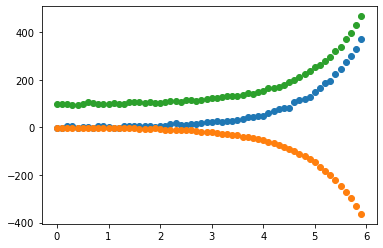

In [2]:
x1 = np.arange(0, 6, 0.1)
y1 = np.exp(x1) + np.random.normal(0, 3, size = x1.shape[0])
y2 = -np.exp(x1) + np.random.normal(0, 1, size = x1.shape[0])
y3 = np.exp(x1) + 100 + np.random.normal(0, 3, size = x1.shape[0])
plt.scatter(x1, y1)
plt.scatter(x1, y2)
plt.scatter(x1, y3)
plt.show()

In [3]:
class model(nn.Module):
    def __init__(self, input_dim, inner_dim=20, output_dim=1):
        """
        Args:
            input_dim: 128 for latent space + 3 points = 131
        """
        super(model, self).__init__()
        # MLP
        layers = []
        for _ in range(2):
            layers.append(nn.Sequential(nn.Linear(input_dim, inner_dim), nn.ReLU()))
            input_dim = inner_dim
        layers.append(nn.Sequential(nn.Linear(input_dim, output_dim)))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        sdf = self.net(x)
        return sdf

In [4]:
# Problem setting
latent_size = 128
input_dim = latent_size + 1  # network input
num_classes = 3

# convert x1 and x2 data points to torch
x1_torch = torch.tensor(x1, dtype=torch.float32)

# generate latent code
latent1_class = torch.full((x1.shape[0], 1), 0, dtype=torch.float32)
latent2_class = torch.full((x1.shape[0], 1), 1, dtype=torch.float32)
latent3_class = torch.full((x1.shape[0], 1), 2, dtype=torch.float32)

# dataset
data1 = torch.hstack((latent1_class, x1_torch.view(-1, 1)))
data2 = torch.hstack((latent2_class, x1_torch.view(-1, 1)))
data3 = torch.hstack((latent3_class, x1_torch.view(-1, 1)))
data = torch.vstack((data1, data2, data3))
# ground truth
gt1 = torch.tensor(y1, dtype=torch.float32).view(-1, 1)
gt2 = torch.tensor(y2, dtype=torch.float32).view(-1, 1)
gt3 = torch.tensor(y3, dtype=torch.float32).view(-1, 1)
gt = torch.vstack((gt1, gt2, gt3))

"""
1 col = latent class
2 col = x
3 col = y
"""
data_gt = torch.hstack((data, gt))

# Train

In [5]:
epochs = 20

# initialise latent codes
torch.manual_seed(42)
latent1 = torch.normal(0, 0.01, size = (1, latent_size), dtype=torch.float32)
latent2 = torch.normal(0, 0.01, size = (1, latent_size), dtype=torch.float32)
latent3 = torch.normal(0, 0.01, size = (1, latent_size), dtype=torch.float32)
unique_latents = torch.vstack((latent1, latent2, latent3))
unique_latents.requires_grad_()

train_loader = DataLoader(
                data_gt,
                batch_size=1,
                shuffle=True,
                drop_last=True)

In [ ]:
unique_latents.shape

In [6]:
def loss_function(gt, predicted, latent, sigma=0.01):
    l1 = torch.mean(torch.abs(gt - predicted))
    l2 = sigma * torch.sum(torch.pow(latent,2))
    loss = l1 + l2
    return loss

In [8]:
modello = model(input_dim)
modello.train()

params_dict = dict()
for name, params in modello.named_parameters():
    params_dict[name] = params.clone()

optim1 = torch.optim.SGD(modello.parameters(), lr=0.0005)
optim2 = torch.optim.SGD([unique_latents], lr=0.0005)

latent_list = np.array([]).reshape(0, num_classes, latent_size)

loss_list = []

loss = nn.L1Loss()
for total_iterations in tqdm(range(0, 20)):
    for epoch in range(epochs):
        iterations = 0.0
        total_loss = 0.0
        for batch in train_loader:
            optim2.zero_grad()
            latent_class = int(batch[:, 0].type(torch.float32).item())
            y = batch[:, 2].type(torch.float32)
            x = torch.hstack((unique_latents[latent_class], batch[0, 1]))
            output = modello(x)
            loss_value = loss_function(y, output, unique_latents[latent_class])
            loss_value.backward()
            for i in range(0, unique_latents.shape[0]):
                if i != latent_class:
                    unique_latents.grad[i, :].data.zero_()   
            optim2.step()
            total_loss += loss_value.item()
            iterations += 1.0
            latent_list = np.vstack((latent_list, unique_latents.detach().cpu()[None, :, :]))
        loss_list.append(total_loss/iterations) 
        
    # set gradients to zero
    optim2.zero_grad()    
 
    for epoch in range(epochs):
        iterations = 0.0
        total_loss = 0.0
        for batch in train_loader:
            optim1.zero_grad()
            latent_class = int(batch[:, 0].type(torch.float32).item())
            y = batch[:, 2].type(torch.float32)
            x = torch.hstack((unique_latents[latent_class], batch[0, 1]))
            output = modello(x)
            loss_value = loss_function(y, output, unique_latents[latent_class])
            loss_value.backward()            
            optim1.step()
            total_loss += loss_value.item()
            iterations += 1.0
        loss_list.append(total_loss/iterations)
                
    optim1.zero_grad()
    unique_latents.grad.data.zero_()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [17:55<00:00, 53.80s/it]


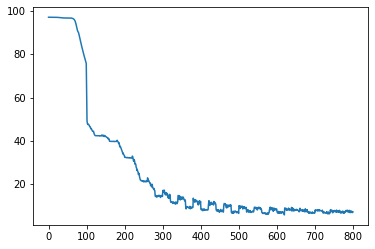

In [9]:
plt.plot(loss_list)
plt.show()

In [ ]:
latent_list.shape

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(latent_list[0])
plt.scatter(X_embedded[0, 0], X_embedded[0, 1], label='First latent vector first')
plt.scatter(X_embedded[1, 0], X_embedded[1, 1], label='Second latent vector first')
plt.scatter(X_embedded[2, 0], X_embedded[2, 1], label='Third latent vector first')

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(latent_list[-1])
plt.scatter(X_embedded[0, 0], X_embedded[0, 1], label='First latent vector last')
plt.scatter(X_embedded[1, 0], X_embedded[1, 1], label='Second latent vector last')
plt.scatter(X_embedded[2, 0], X_embedded[2, 1], label='Third latent vector last')

plt.legend()
plt.show()

In [ ]:
X_embedded[None, :, :]

In [ ]:
a = [[float(item)/float(latent_list.shape[0]), 0, 1] for item in range(latent_list.shape[0])]
b = [[float(item)/float(latent_list.shape[0]), 1, 0] for item in range(latent_list.shape[0])]

plt.scatter(latent_list[:, 0, 0], latent_list[:, 0, 1], c=a, label='First latent vector')
plt.scatter(latent_list[:, 1, 0], latent_list[:, 1, 1], c=b, label='Second latent vector')
plt.legend()
plt.show()

### Video of latent space

In [ ]:
# Settings
num_steps = latent_list.shape[0]
        
def animate_scatters(iteration, data, scatter_lc1, scatter_lc2):
    """
    Update the data held by the scatter plot and therefore animates it.
    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)
    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    scatter_lc1.set_offsets([data[iteration, 0, 0], data[iteration, 0, 1]])
    scatter_lc2.set_offsets([data[iteration, 1, 0], data[iteration, 1, 1]])
    return scatter_lc1, scatter_lc2

# Attaching 3D axis to the figure
fig = plt.figure(figsize=(7, 7))
ax = fig.subplots()

# Create plots
scatter_lc1 = ax.scatter(latent_list[0, 0, 0], latent_list[0, 0, 1], s=40)
scatter_lc2 = ax.scatter(latent_list[0, 1, 0], latent_list[0, 1, 1], s=40)

# Setting the axes properties
ax.set(xlim=(-3, 5), xlabel='X')
ax.set(ylim=(-1.5, 1.5), ylabel='Y')

# Creating the Animation object
anim_gt = animation.FuncAnimation(
    fig, animate_scatters, num_steps, fargs=(latent_list, scatter_lc1, scatter_lc2), interval=5)
HTML(anim_gt.to_html5_video())

# Inference
Given a set of x and y, we want to infer corresponding latent code.

In [ ]:
# initialise latent codes
torch.manual_seed(24)

# dataset
xt1 = np.arange(-1, 5, 0.01)
yt1 = np.exp(xt1) + np.random.normal(0, 5, size = xt1.shape[0])
# convert x1 and x2 data points to torch
xt1_torch = torch.tensor(xt1, dtype=torch.float32).view(-1, 1)
# ground truth
gtt1 = torch.tensor(yt1, dtype=torch.float32).view(-1, 1)

"""
1 col = latent class
2 col = x
3 col = y
"""
data_1 = torch.hstack((xt1_torch, gtt1))
print(data_1.shape[0])
num_choices = 50
indexes = torch.arange(0, data_1.shape[0])
rand_indexes = indexes[torch.randint(len(indexes),(num_choices,))] 
data_test = data_1[rand_indexes]

test_loader = DataLoader(
                data_test,
                batch_size=num_choices,
                shuffle=True,
                drop_last=True)

In [ ]:
# initialise random latent code
test_lc = torch.normal(0, 0.01, size = (1, latent_size), dtype=torch.float32)
test_lc.requires_grad_()

test_lc_list = np.array([]).reshape(0, latent_size)

optim3 = torch.optim.Adam([test_lc], lr=0.0005)

loss = nn.L1Loss()

loss_list_test = []

# set gradients to zero
for params in modello.parameters():
    params.grad.data.zero_()
    
for epoch in tqdm(range(50000)):
    iterations = 0.0
    total_loss = 0.0
           
    for batch in test_loader:
        optim3.zero_grad()
        y = batch[:, 1].type(torch.float32).view(-1, 1)
        x_partial = batch[:, 0].view(-1, 1)
        latent_tile = test_lc.tile(x_partial.shape[0], 1)
        x_full = torch.hstack((latent_tile, x_partial))
        output = modello(x_full)
        loss_value = torch.sum(torch.abs(y - output))# + torch.sum(torch.pow(test_lc,2))
        #print('grad before: ', test_lc.grad)
        #print('latent code before: ', test_lc)        
        loss_value.backward()  
        #torch.nn.utils.clip_grad_norm_(test_lc, 10)
        optim3.step()
        #print('grad after: ', test_lc.grad)
        #print('latent code after: ', test_lc)  

        total_loss += loss_value.item()
        iterations += 1.0
        test_lc_list = np.vstack((test_lc_list, test_lc.detach().numpy()))
    loss_list_test.append(total_loss/iterations) 
        
    optim3.zero_grad()

In [ ]:
print(f'regulariser: {1 * torch.sum(torch.pow(test_lc,2))}')
print(f'l1: {torch.sum(torch.abs(y - output))}')

In [ ]:
test_lc

In [ ]:
plt.plot(loss_list_test)
plt.show()
print(loss_list_test[-1])

In [ ]:
# test
optimised_latent_code = torch.tensor(test_lc_list[-1], dtype=torch.float32)
# training
#optimised_latent_code = torch.tensor(latent_list[-1, 0], dtype=torch.float32)

optimised_latent_code_tile = optimised_latent_code.tile(data_test.shape[0], 1)
output = modello(torch.hstack((optimised_latent_code_tile, data_test[:, 0].view(-1, 1))))

plt.scatter(data_test[:, 0].detach().numpy(), output.detach().numpy())
plt.scatter(data_test[:, 0].detach().numpy(), data_test[:, 1].detach().numpy())
plt.show()

In [ ]:
optimised_latent_code

In [ ]:
torch.tensor(latent_list[-1, 0], dtype=torch.float32)

In [ ]:
torch.sum(torch.pow(optimised_latent_code,2))

In [ ]:
torch.mean(torch.abs(y - output))

# Basics

In [33]:
l1 = nn.MSELoss()
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
optim = torch.optim.SGD([x], lr=0.001)
optim.zero_grad()
input_tensor_all = torch.vstack((x[:, 0].view(1, 2, 1), x[:, 1].view(1, 2, 1)))
input_tensor_1 = x[:, 0].view(1, 2, 1)
input_tensor_2 = x[:, 1].view(1, 2, 1)

a = torch.tensor([[0.5, 1.5]], requires_grad=True)
y = torch.tensor([[6.0], [7.0]])
pred = input_tensor_all @ a
l1_value = l1(y, pred)
print(l1_value)
l1_value.backward()

print(x)
print(x.grad)
optim.step()
print(x)

tensor(18.3750, grad_fn=<MseLossBackward>)
tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
tensor([[-2.3750, -1.7500],
        [-1.6250, -1.0000]])
tensor([[1.0024, 2.0017],
        [3.0016, 4.0010]], requires_grad=True)


In [ ]:
tensor(18.3750, grad_fn=<MseLossBackward>)
tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
tensor([[-2.3750, -1.7500],
        [-1.6250, -1.0000]])
tensor([[1.0024, 2.0017],
        [3.0016, 4.0010]], requires_grad=True)